<center><h1>Tang_Lin_HW5</h1></center>
<br>
<br>

Name: Tang Lin
<br>
Github Username: MeLinOrDoreen
<br>
USC ID: 9012859074

## 1. Decision Trees as Interpretable Models

Import packages

In [386]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import math
import xgboost as xgb

from sklearn import tree, preprocessing
from sklearn.tree import _tree

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# to surpress warnings
import warnings
warnings.filterwarnings("ignore")

### (a) Obtain Data

Get the Accute Inamations Data Set

In [387]:
diagnosis_df = pd.read_csv("../Data/diagnosis.data", encoding="UTF-16", header=None, delimiter="\t", decimal=",")
diagnosis_df

,0,1,2,3,4,5,6,7
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no
...,...,...,...,...,...,...,...,...
115,41.4,no,yes,yes,no,yes,no,yes
116,41.5,no,no,no,no,no,no,no
117,41.5,yes,yes,no,yes,no,no,yes
118,41.5,no,yes,yes,no,yes,no,yes


In [388]:
column_names = ["Temperature", "Nausea", "Lumbar_pain", "Urine_pushing", 
                "Micturition_pain", "Burning", "Inflammation", "Nephritis"]
diagnosis_df.columns = column_names
diagnosis_df

,Temperature,Nausea,Lumbar_pain,Urine_pushing,Micturition_pain,Burning,Inflammation,Nephritis
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no
...,...,...,...,...,...,...,...,...
115,41.4,no,yes,yes,no,yes,no,yes
116,41.5,no,no,no,no,no,no,no
117,41.5,yes,yes,no,yes,no,no,yes
118,41.5,no,yes,yes,no,yes,no,yes


### (b) Build a decision tree

In [389]:
# Multi-label
X = diagnosis_df.iloc[:, 0:-2]
y = diagnosis_df.iloc[:, -2:]

In [390]:
# In X, convert all yes & no to 1 & 0
X_converted = X.replace({'yes': 1, 'no': 0})
X_converted

,Temperature,Nausea,Lumbar_pain,Urine_pushing,Micturition_pain,Burning
0,35.5,0,1,0,0,0
1,35.9,0,0,1,1,1
2,35.9,0,1,0,0,0
3,36.0,0,0,1,1,1
4,36.0,0,1,0,0,0
...,...,...,...,...,...,...
115,41.4,0,1,1,0,1
116,41.5,0,0,0,0,0
117,41.5,1,1,0,1,0
118,41.5,0,1,1,0,1


In [391]:
# Preprocessing the multilabeled y
y_combined = y.apply(lambda row: f"{row['Inflammation']}_{row['Nephritis']}", axis=1)
y_combined = pd.DataFrame(y_combined, columns=["CombinedLabel"])

LE = preprocessing.LabelEncoder()
y_encoded = LE.fit_transform(y_combined)
y_encoded = pd.DataFrame(y_encoded, columns=["CombinedLabel"])
y_encoded

,CombinedLabel
0,0
1,2
2,0
3,2
4,0
...,...
115,1
116,0
117,1
118,1


CombinedLabel = 0 -> 'no_no'
<br>
CombinedLabel = 1 -> 'no_yes'
<br>
CombinedLabel = 2 -> 'yes_no'
<br>
CombinedLabel = 3 -> 'yes_yes'

In [392]:
# Set the classifier and fit in data
classifier = tree.DecisionTreeClassifier()
classifier.fit(X_converted, y_encoded)

DecisionTreeClassifier()

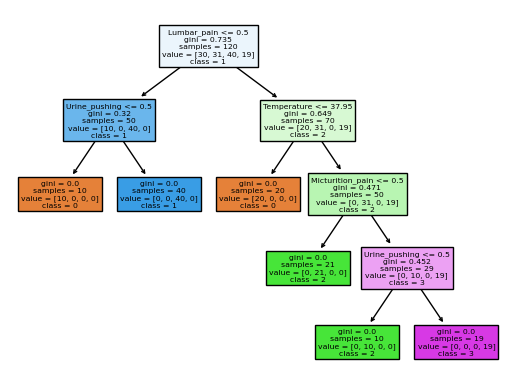

In [393]:
# Visualize the classification tree
tree.plot_tree(classifier, filled=True, feature_names=list(X_converted.columns), 
               class_names=list(str(element) for element in list(y_encoded["CombinedLabel"].unique())))
plt.show()

### (c) Convert the decision rules

In [394]:
def tree_to_code(tree, feature_names):
	"""
	Outputs a decision tree model as a Python function
	
	Parameters:
	-----------
	tree: decision tree model
		The decision tree to represent as a function
	feature_names: list
		The feature names of the dataset used for building the decision tree
	"""

	tree_ = tree.tree_
	feature_name = [
		feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
		for i in tree_.feature
	]
	print("def tree({}):".format(", ".join(feature_names)))

	def recurse(node, depth):
		indent = "  " * depth
		if tree_.feature[node] != _tree.TREE_UNDEFINED:
			name = feature_name[node]
			threshold = tree_.threshold[node]
			print("{}if {} <= {}:".format(indent, name, threshold))
			recurse(tree_.children_left[node], depth + 1)
			print("{}else:  # if {} > {}".format(indent, name, threshold))
			recurse(tree_.children_right[node], depth + 1)
		else:
			print("{}return {}".format(indent, tree_.value[node]))

	recurse(0, 1)


In [395]:
tree_to_code(classifier, list(X_converted.columns))

def tree(Temperature, Nausea, Lumbar_pain, Urine_pushing, Micturition_pain, Burning):
  if Lumbar_pain <= 0.5:
    if Urine_pushing <= 0.5:
      return [[10.  0.  0.  0.]]
    else:  # if Urine_pushing > 0.5
      return [[ 0.  0. 40.  0.]]
  else:  # if Lumbar_pain > 0.5
    if Temperature <= 37.95000076293945:
      return [[20.  0.  0.  0.]]
    else:  # if Temperature > 37.95000076293945
      if Micturition_pain <= 0.5:
        return [[ 0. 21.  0.  0.]]
      else:  # if Micturition_pain > 0.5
        if Urine_pushing <= 0.5:
          return [[ 0. 10.  0.  0.]]
        else:  # if Urine_pushing > 0.5
          return [[ 0.  0.  0. 19.]]


### (d) Pruning

In [396]:
# Cost-complexity pruning: Find the optimal pruning alpha
path = classifier.cost_complexity_pruning_path(X_converted, y_encoded)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Train Decision Trees for various alpha values and select the best tree
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_converted, y_encoded)
    clfs.append(clf)

# Find the best alpha (smallest alpha with the largest accuracy)
acc_scores = [clf.score(X_converted, y_encoded) for clf in clfs]
best_alpha = ccp_alphas[acc_scores.index(max(acc_scores))]

# Train the final decision tree with the best alpha
final_classifier = tree.DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
final_classifier.fit(X_converted, y_encoded)


DecisionTreeClassifier(random_state=42)

In [397]:
best_alpha

0.0

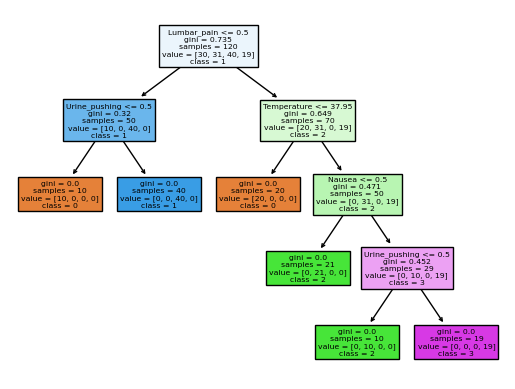

In [398]:
# Visualize the classification tree
tree.plot_tree(final_classifier, filled=True, feature_names=list(X_converted.columns), 
               class_names=list(str(element) for element in list(y_encoded["CombinedLabel"].unique())))
plt.show()

In [399]:
tree_to_code(final_classifier, list(X_converted.columns))

def tree(Temperature, Nausea, Lumbar_pain, Urine_pushing, Micturition_pain, Burning):
  if Lumbar_pain <= 0.5:
    if Urine_pushing <= 0.5:
      return [[10.  0.  0.  0.]]
    else:  # if Urine_pushing > 0.5
      return [[ 0.  0. 40.  0.]]
  else:  # if Lumbar_pain > 0.5
    if Temperature <= 37.95000076293945:
      return [[20.  0.  0.  0.]]
    else:  # if Temperature > 37.95000076293945
      if Nausea <= 0.5:
        return [[ 0. 21.  0.  0.]]
      else:  # if Nausea > 0.5
        if Urine_pushing <= 0.5:
          return [[ 0. 10.  0.  0.]]
        else:  # if Urine_pushing > 0.5
          return [[ 0.  0.  0. 19.]]


## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [400]:
# Read the data into a data frame
communities_df = pd.read_csv("../Data/communities.data",header=None, delimiter=",")
communities_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [401]:
# Specify the path to the .names file
file_path = "../Data/communities.names"

# Read column names from the .names file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Extract column names using regular expression
column_names = []
for line in lines:
    if line.startswith('@attribute'):
        # Extract column name using regex
        match = re.search(r'@attribute\s+(\S+)', line)
        if match:
            column_name = match.group(1)
            column_names.append(column_name)

# Print the list of column names
print(column_names)
print(len(column_names))

['state', 'county', 'community', 'communityname', 'fold', 'population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOn

In [402]:
# Rename the column names in the communities data frame
communities_df.columns = column_names
communities_df

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [403]:
# First 1495 rows as training set and rest as test set
training_set = communities_df.iloc[0:1495, :]
test_set = communities_df.iloc[1495:, :]
print(training_set.shape)
print(test_set.shape)

(1495, 128)
(499, 128)


### (b) Missing values

In [404]:
# Change all the "?" values into np.nan
communities_df.replace("?", np.nan, inplace= True)

In [405]:
# Get the columns with miss values
columns_mv = communities_df.columns[communities_df.isna().any()].tolist()
columns_mv

['county',
 'community',
 'OtherPerCap',
 'LemasSwornFT',
 'LemasSwFTPerPop',
 'LemasSwFTFieldOps',
 'LemasSwFTFieldPerPop',
 'LemasTotalReq',
 'LemasTotReqPerPop',
 'PolicReqPerOffic',
 'PolicPerPop',
 'RacialMatchCommPol',
 'PctPolicWhite',
 'PctPolicBlack',
 'PctPolicHisp',
 'PctPolicAsian',
 'PctPolicMinor',
 'OfficAssgnDrugUnits',
 'NumKindsDrugsSeiz',
 'PolicAveOTWorked',
 'PolicCars',
 'PolicOperBudg',
 'LemasPctPolicOnPatr',
 'LemasGangUnitDeploy',
 'PolicBudgPerPop']

From the data description, all the non-predictive columns are:
<br>
-- state
<br>
-- county
<br>
-- community
<br>
-- communityname
<br>
-- fold

In [406]:
# Remove non predictive Columns from the list 
columns_nonpreditive = ["state", "county", "community", "communityname", "fold"]

columns_mv_predictive = [x for x in columns_mv if x not in columns_nonpreditive]

In [407]:
# Sum how many missing values are in those columns
communities_df[columns_mv_predictive].isna().sum()

OtherPerCap                1
LemasSwornFT            1675
LemasSwFTPerPop         1675
LemasSwFTFieldOps       1675
LemasSwFTFieldPerPop    1675
LemasTotalReq           1675
LemasTotReqPerPop       1675
PolicReqPerOffic        1675
PolicPerPop             1675
RacialMatchCommPol      1675
PctPolicWhite           1675
PctPolicBlack           1675
PctPolicHisp            1675
PctPolicAsian           1675
PctPolicMinor           1675
OfficAssgnDrugUnits     1675
NumKindsDrugsSeiz       1675
PolicAveOTWorked        1675
PolicCars               1675
PolicOperBudg           1675
LemasPctPolicOnPatr     1675
LemasGangUnitDeploy     1675
PolicBudgPerPop         1675
dtype: int64

In [408]:
# We use the mean to replace the missing value in the set
for col in columns_mv_predictive:
    if communities_df[col].dtype == "float" or communities_df[col].dtype == "int64":
        mean = communities_df[col].mean(skipna=True)
        communities_df[col].replace(np.nan, mean, inplace=True)
    else:
        communities_df[col] = pd.to_numeric(communities_df[col])
        mean = communities_df[col].mean(skipna=True)
        communities_df[col].replace(np.nan, mean, inplace=True)
        

In [409]:
# Check if we have replaced all the missing values with means for predictive columns
communities_df.columns[communities_df.isna().any()]

Index(['county', 'community'], dtype='object')

In [410]:
# Redefine our training and test set
training_set = communities_df.iloc[0:1495, :]
test_set = communities_df.iloc[1495:, :]
print(training_set.shape)
print(test_set.shape)

(1495, 128)
(499, 128)


### (c) Plot a correlation matrix

In [411]:
communities_df

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


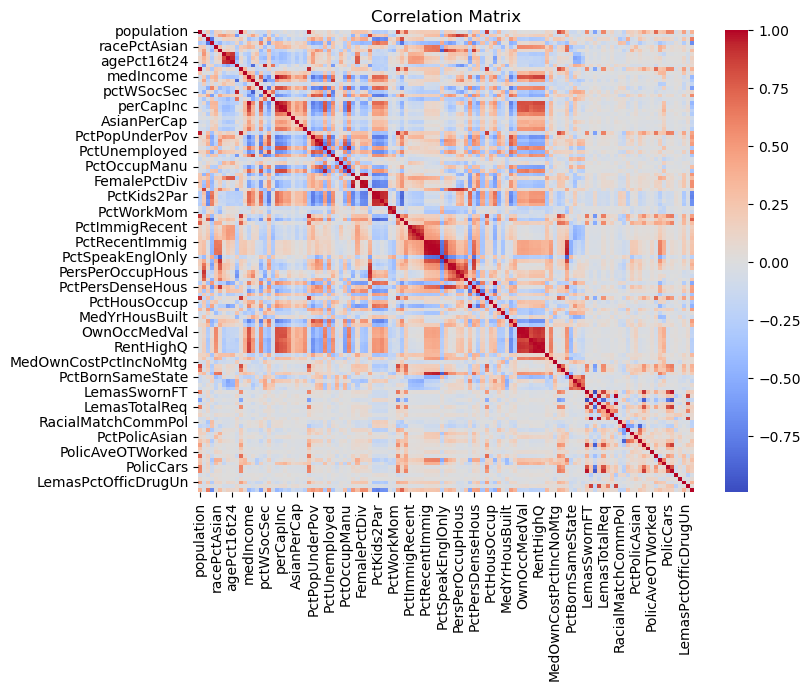

In [412]:
# Calculate the correlation matrix
correlation_matrix = communities_df.iloc[:, 5:].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [413]:
# Filter only numeric columns
numeric_cols = communities_df.select_dtypes(include=['number'])

# Calculate Coefficient of Variation for each feature
coefficients_of_variation = numeric_cols.std() / numeric_cols.mean()

coefficients_of_variation

state                  0.571671
fold                   0.523062
population             2.203503
householdsize          0.353298
racepctblack           1.410920
                         ...   
LemasPctPolicOnPatr    0.122331
LemasGangUnitDeploy    0.368040
LemasPctOfficDrugUn    2.555266
PolicBudgPerPop        0.337281
ViolentCrimesPerPop    0.979015
Length: 125, dtype: float64

### (e) Scatter plots and box plots for highest CV features

In [414]:
n = math.floor(math.sqrt(128))
highest_n_cv = coefficients_of_variation.sort_values(ascending=False)[0:n]
highest_n_cv

NumStreet              4.407702
NumInShelters          3.485481
NumIlleg               2.994196
NumImmig               2.900497
LemasPctOfficDrugUn    2.555266
NumUnderPov            2.304970
population             2.203503
numbUrban              2.001744
HousVacant             1.958780
LandArea               1.678031
racePctHisp            1.614278
dtype: float64

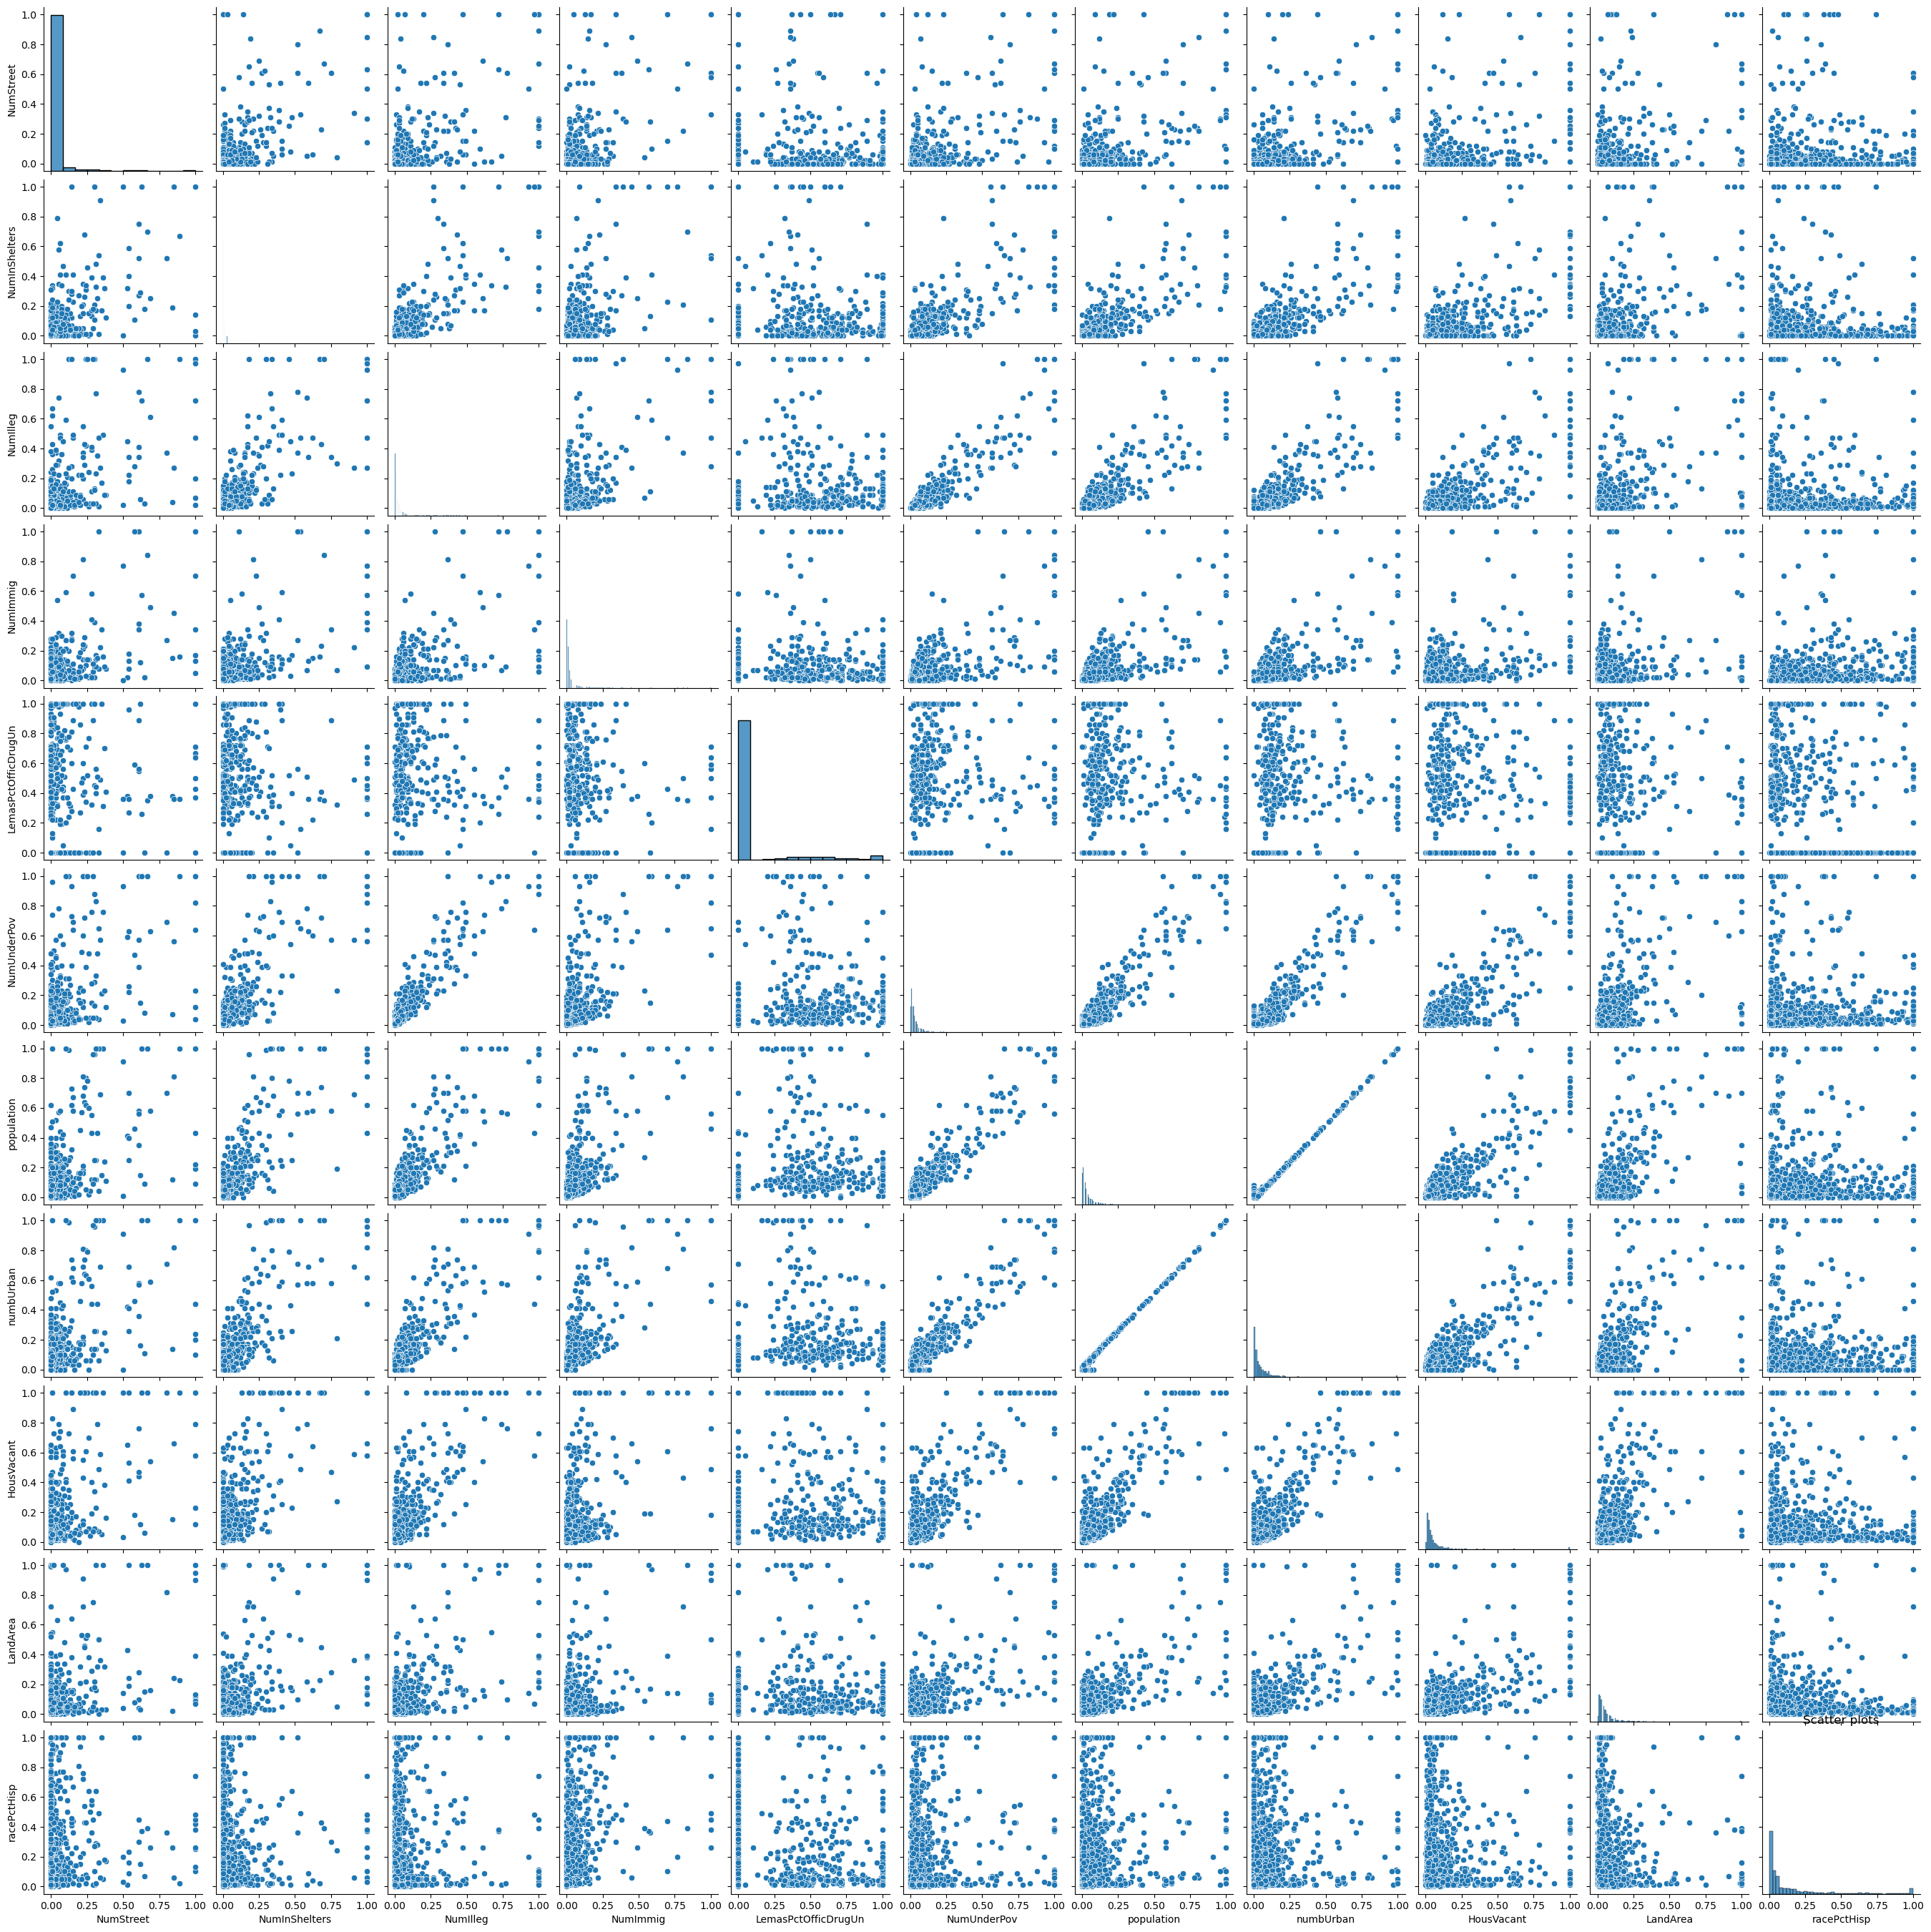

In [415]:
# Scatter plots between these 11 features
sns.pairplot(communities_df[highest_n_cv.index])
plt.title("Scatter plots")
plt.show()

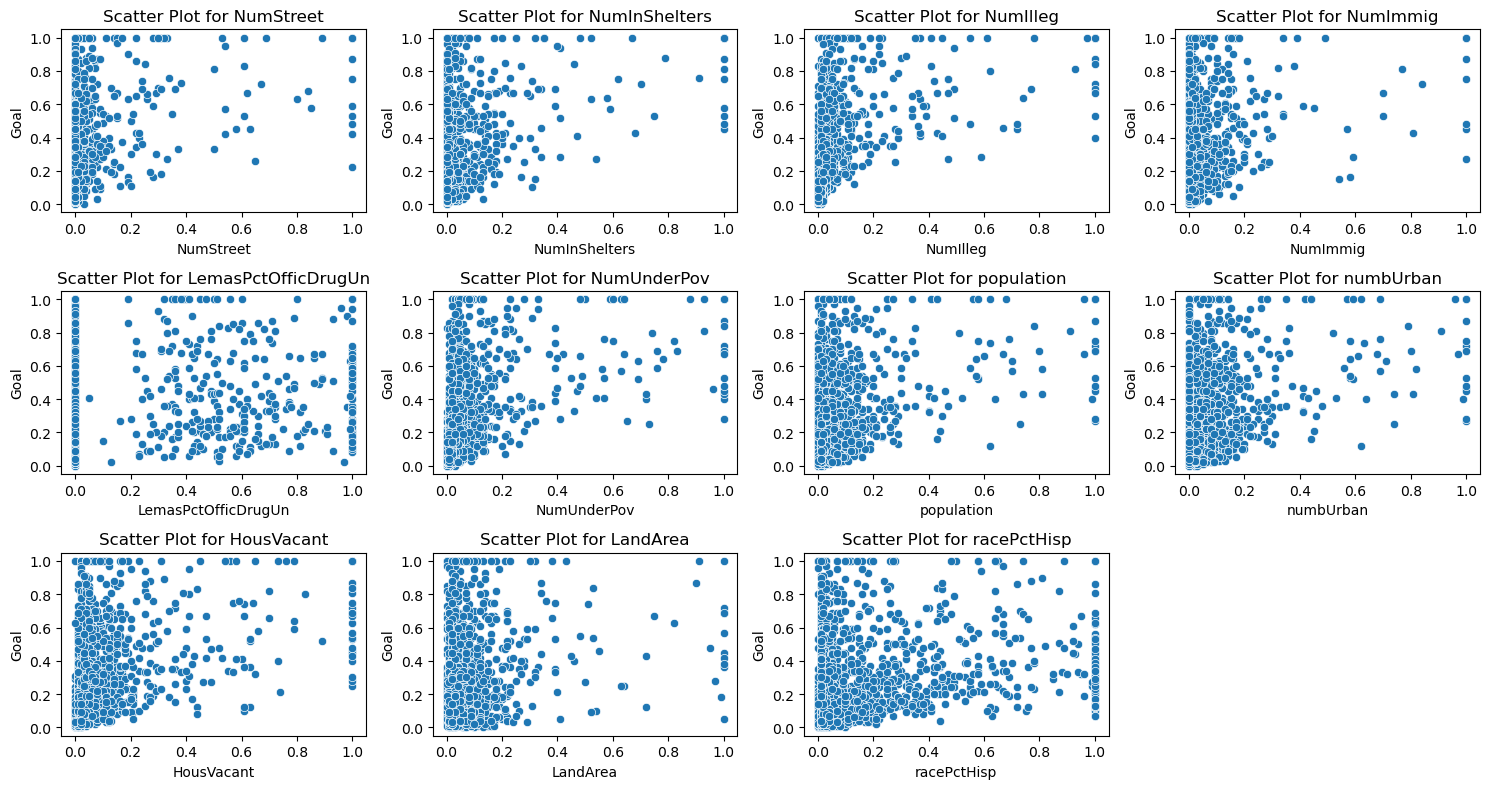

In [416]:
# Scatter plot of these 11 features and our GOAL feature
plt.figure(figsize=(15, 8))
for index, feature in enumerate(communities_df[highest_n_cv.index], start=1):
    plt.subplot(3, 4, index)  # 3 rows, 4 columns layout for 11 features
    sns.scatterplot(x=feature, y='ViolentCrimesPerPop', data=communities_df)
    plt.title(f'Scatter Plot for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Goal')
    
plt.tight_layout()
plt.show()

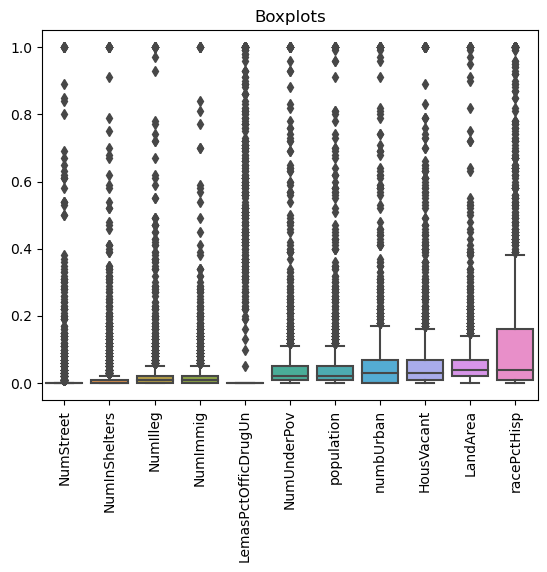

In [417]:
# Boxplots
sns.boxplot(communities_df[highest_n_cv.index])
plt.title("Boxplots")
plt.xticks(rotation=90) 
plt.show()

As we can see from scatter plots, there are clusters between our target and 11 features, and also, there are clusters and linear relationship between 11 features. These info can offer indications of the significance of the features in predicting the target variable. 

### (f) Fit a linear model

In [418]:
X_train = training_set.iloc[:, 5:-1] # Exclude the first 4 unrelevant features
y_train = training_set.iloc[:, -1:]

X_test = test_set.iloc[:, 5:-1]
y_test = test_set.iloc[:, -1:]

In [419]:
y_train

,ViolentCrimesPerPop
0,0.20
1,0.67
2,0.43
3,0.12
4,0.03
...,...
1490,0.03
1491,0.20
1492,0.30
1493,0.03


In [420]:
# Fit a linear regression model using least squares
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = linear_model.predict(X_test)

# Calculate Mean Squared Error (MSE) as the test error
test_error_linear = mean_squared_error(y_test, predictions)

print(f'Test Error (MSE): {test_error_linear:.2f}')

Test Error (MSE): 0.79


### (g) Fit a ridge regression model

In [421]:
# Perform cross-validation to choose the best lambda (alpha)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}  # List of lambda values to try
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5)  # 5-fold cross-validation
grid_search.fit(X_train, y_train)

# Get the best lambda (alpha) from cross-validation
best_alpha = grid_search.best_params_['alpha']

# Fit the Ridge regression model with the best lambda on the training set
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = ridge_model.predict(X_test)

# Calculate Mean Squared Error (MSE) as the test error
test_error_ridge = mean_squared_error(y_test, predictions)

print(f'Best Alpha (Lambda): {best_alpha}')
print(f'Test Error (MSE) with Ridge Regression: {test_error_ridge:.2f}')

Best Alpha (Lambda): 1
Test Error (MSE) with Ridge Regression: 0.02


### (h) Fit a LASSO model

In [422]:
# Fit LASSO model without standardization
lasso_model = Lasso()
lasso_grid_search = GridSearchCV(estimator=lasso_model, param_grid={'alpha': [0.01, 0.1, 1, 10, 100]}, cv=5)
lasso_grid_search.fit(X_train, y_train)

best_alpha = lasso_grid_search.best_params_['alpha']
lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train, y_train)

# Make predictions and calculate test error for non-standardized features
predictions_non_standardized = lasso_model.predict(X_test)
test_error_non_standardized = mean_squared_error(y_test, predictions_non_standardized)
selected_features_non_standardized = list(X_train.columns[lasso_model.coef_ != 0])

print(f'Test Error (MSE) without Standardization: {test_error_non_standardized:.2f}')
print(f'Selected Features without Standardization: {selected_features_non_standardized}')

Test Error (MSE) without Standardization: 0.02
Selected Features without Standardization: ['racePctWhite', 'PctKids2Par', 'PctIlleg']


In [423]:
# Standardize features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Fit LASSO model with standardized features
lasso_model_standardized = Lasso()
lasso_grid_search_standardized = GridSearchCV(estimator=lasso_model_standardized, param_grid={'alpha': [0.01, 0.1, 1, 10, 100]}, cv=5)
lasso_grid_search_standardized.fit(X_train_standardized, y_train)

best_alpha_standardized = lasso_grid_search_standardized.best_params_['alpha']
lasso_model_standardized = Lasso(alpha=best_alpha_standardized)
lasso_model_standardized.fit(X_train_standardized, y_train)

# Make predictions and calculate test error for standardized features
predictions_standardized = lasso_model_standardized.predict(X_test_standardized)
test_error_standardized = mean_squared_error(y_test, predictions_standardized)
selected_features_standardized = list(X_train.columns[lasso_model_standardized.coef_ != 0])

print(f'Test Error (MSE) with Standardization: {test_error_standardized:.2f}')
print(f'Selected Features with Standardization: {selected_features_standardized}')


Test Error (MSE) with Standardization: 0.02
Selected Features with Standardization: ['racepctblack', 'racePctWhite', 'pctUrban', 'MalePctDivorce', 'PctKids2Par', 'PctWorkMom', 'PctIlleg', 'PctPersDenseHous', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'MedRentPctHousInc', 'NumStreet', 'PctForeignBorn']


We have the same MSE for both situation, but the standardiztion method includes more features in the data. 

### (i) Fit a PCR model

In [424]:
# Create a pipeline for PCA and Linear Regression
pipeline = Pipeline([
    ('pca', PCA()),
    ('regression', LinearRegression())
])

# Perform GridSearchCV for selecting the number of principal components (M)
param_grid = {'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}  
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)  
grid_search.fit(X_train, y_train)

# Get the best number of principal components (M) from cross-validation
best_components = grid_search.best_params_['pca__n_components']

In [425]:
# Fit the PCA and Linear Regression model with the best number of components on the training set
pipeline = Pipeline([
    ('pca', PCA(n_components=best_components)),
    ('regression', LinearRegression())
])
pipeline.fit(X_train, y_train)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

# Calculate Mean Squared Error (MSE) as the test error
test_error_pca = mean_squared_error(y_test, predictions)

print(f'Best Number of Principal Components (M): {best_components}')
print(f'Test Error (MSE) with PCR: {test_error_pca:.2f}')

Best Number of Principal Components (M): 10
Test Error (MSE) with PCR: 0.02


### (j) Fit a boosting tree

In [426]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'alpha': [0, 0.1, 0.5, 1, 1.5]  # Try different values of alpha
}

# Initialize XGBoost Regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Perform GridSearchCV to find the best alpha
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best alpha from cross-validation
best_alpha = grid_search.best_params_['alpha']

# Fit the L1 penalized gradient boosting tree using the best alpha
final_model = xgb.XGBRegressor(objective='reg:squarederror', alpha=best_alpha)
final_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = final_model.predict(X_test)

# Calculate Mean Squared Error (MSE) as the test error
test_error_xgb = mean_squared_error(y_test, predictions)

print(f'Best Alpha: {best_alpha}')
print(f'Test Error (MSE) with L1 Penalized Gradient Boosting Tree: {test_error_xgb:.2f}')


Best Alpha: 1
Test Error (MSE) with L1 Penalized Gradient Boosting Tree: 0.02
